<a href="https://colab.research.google.com/github/neigit485/Challenge_Data_Science/blob/main/TelecomX_Churn_Analise_Completa_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom X — Análise Completa de Evasão de Clientes (Churn)

Versão **completa** do projeto, com:
- ETL com `pandas` (foco principal)
- Exploração univariada e bivariada
- Análises multivariadas (combinações de contrato, internet, pagamento e tenure)
- Segmentação de perfis de alto/baixo risco
- Gráficos em português do Brasil (nomes de categorias e eixos)

## Como usar este notebook no Google Colab

1. Baixe o arquivo `TelecomX_Data.json` do GitHub da Alura (ou do seu repositório):
   - https://github.com/alura-cursos/challenge2-data-science/blob/main/TelecomX_Data.json
2. No Colab, faça upload do arquivo `TelecomX_Data.json` para o diretório de trabalho (ícone de pasta → botão de upload).
3. Execute as células na ordem.

> Observação: o notebook tenta primeiro ler o arquivo **local** `TelecomX_Data.json`. Se não encontrar, faz fallback para a URL do GitHub (isso ajuda a evitar erros).

##Importação de Bibliotecas

In [ ]:
!pip -q install pandas numpy matplotlib seaborn plotly openpyxl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import json

sns.set_theme(style='whitegrid')

print('Versões:')
print('pandas:', pd.__version__)
print('numpy :', np.__version__)

Versões:
pandas: 2.2.2
numpy : 2.0.2


##Extração

In [ ]:
arquivo_json = 'TelecomX_Data.json'

try:
    with open(arquivo_json, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f'Lido a partir do arquivo local: {arquivo_json}')
except FileNotFoundError:
    url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/main/TelecomX_Data.json'
    resp = requests.get(url, timeout=60)
    resp.raise_for_status()
    data = resp.json()

# Normalização
df_raw = pd.json_normalize(data)

print('Dimensão (linhas, colunas):', df_raw.shape)
display(df_raw.head(3))
print('\nColunas originais:')
print(df_raw.columns.tolist())

Dimensão (linhas, colunas): (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85



Colunas originais:
['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total']


##Transformação

In [ ]:
import re

def to_snake(s: str) -> str:
    s = s.replace(' ', '_')
    s = re.sub(r'[^0-9a-zA-Z_\.]+', '', s)
    s = s.replace('.', '_')
    s = re.sub(r'_+', '_', s)
    return s.strip('_').lower()

df = df_raw.copy()
df.columns = [to_snake(c) for c in df.columns]

for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

num_cols = ['customer_seniorcitizen','customer_tenure','account_charges_monthly','account_charges_total']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df['churn_flag'] = (df['churn'].str.lower() == 'yes').astype(int)

bins = [-1, 6, 12, 24, 48, 72, 120]
labels = ['0-6', '7-12', '13-24', '25-48', '49-72', '73+']
df['faixa_tenure'] = pd.cut(df['customer_tenure'], bins=bins, labels=labels)

print('Dimensão após tratamento:', df.shape)
display(df.head(3))

Dimensão após tratamento: (7267, 23)


,customerid,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,churn_flag,faixa_tenure
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,0,7-12
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0,7-12
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,0-6


###Colunas para visualização


In [ ]:
# Mapas de tradução (apresentação)
map_churn = {'Yes': 'Sim', 'No': 'Não'}
map_contrato = {
    'Month-to-month': 'Mês a mês',
    'One year': '1 ano',
    'Two year': '2 anos'
}
map_internet = {
    'Fiber optic': 'Fibra óptica',
    'DSL': 'DSL',
    'No': 'Sem internet'
}
map_pagamento = {
    'Electronic check': 'Cheque eletrônico',
    'Mailed check': 'Cheque via correio',
    'Bank transfer (automatic)': 'Transferência bancária (automático)',
    'Credit card (automatic)': 'Cartão de crédito (automático)'
}
map_sim_nao_servico = {
    'Yes': 'Sim',
    'No': 'Não',
    'No internet service': 'Sem internet',
    'No phone service': 'Sem telefone'
}

# Colunas de churn/contrato/internet/pagamento em pt-br
df['evasao'] = df['churn'].map(map_churn).fillna(df['churn'])
df['contrato_pt'] = df['account_contract'].map(map_contrato).fillna(df['account_contract'])
df['internet_pt'] = df['internet_internetservice'].map(map_internet).fillna(df['internet_internetservice'])
df['pagamento_pt'] = df['account_paymentmethod'].map(map_pagamento).fillna(df['account_paymentmethod'])

# Demais serviços (Sim/Não)
for col in ['internet_onlinesecurity','internet_techsupport','internet_onlinebackup',
            'internet_deviceprotection','internet_streamingtv','internet_streamingmovies',
            'phone_phoneservice','phone_multiplelines','account_paperlessbilling']:
    if col in df.columns:
        df[col + '_pt'] = df[col].map(map_sim_nao_servico).fillna(df[col])

print('Exemplo de colunas traduzidas:')
display(df[['churn','evasao','account_contract','contrato_pt','account_paymentmethod','pagamento_pt','internet_internetservice','internet_pt']].head(5))

Exemplo de colunas traduzidas:


,churn,evasao,account_contract,contrato_pt,account_paymentmethod,pagamento_pt,internet_internetservice,internet_pt
0,No,Não,One year,1 ano,Mailed check,Cheque via correio,DSL,DSL
1,No,Não,Month-to-month,Mês a mês,Mailed check,Cheque via correio,DSL,DSL
2,Yes,Sim,Month-to-month,Mês a mês,Electronic check,Cheque eletrônico,Fiber optic,Fibra óptica
3,Yes,Sim,Month-to-month,Mês a mês,Electronic check,Cheque eletrônico,Fiber optic,Fibra óptica
4,Yes,Sim,Month-to-month,Mês a mês,Mailed check,Cheque via correio,Fiber optic,Fibra óptica


##Exportar dados tratados


In [ ]:
arquivo_saida = 'TelecomX_tratado.csv'
df.to_csv(arquivo_saida, index=False)
print('Arquivo salvo:', arquivo_saida)

Arquivo salvo: TelecomX_tratado.csv


##Visão geral e métricas de churn


In [ ]:
print('Total de clientes:', len(df))
print('Taxa geral de evasão (churn):', f"{df['churn_flag'].mean()*100:.2f}%")

print('\nDistribuição de evasão:')
print(df['evasao'].value_counts(normalize=True).mul(100).round(2).astype(str) + ' %')

Total de clientes: 7267
Taxa geral de evasão (churn): 25.72%

Distribuição de evasão:
evasao
Não     71.2 %
Sim    25.72 %
        3.08 %
Name: proportion, dtype: object


###Resumo numérico por churn

In [ ]:
col_numericas = ['customer_tenure','account_charges_monthly','account_charges_total']
resumo_num = df.groupby('churn_flag')[col_numericas].agg(['mean','median','count']).round(2)
resumo_num

customer_tenure              account_charges_monthly               \
                      mean median count                    mean median count   
churn_flag                                                                     
0                    37.32   37.0  5398                   61.35  64.50  5398   
1                    17.98   10.0  1869                   74.44  79.65  1869   

           account_charges_total                 
                            mean   median count  
churn_flag                                       
0                        2540.44  1669.40  5387  
1                        1531.80   703.55  1869

##Função para calcular quantidade e taxa de evasão por categoria.


In [ ]:
def tabela_churn_por_coluna(df_: pd.DataFrame, col: str, flag_col: str = 'churn_flag') -> pd.DataFrame:
    tmp = df_[[col, flag_col]].dropna()
    out = (tmp.groupby(col)
              .agg(qtd_clientes=(flag_col, 'size'), taxa_evasao=(flag_col, 'mean'))
              .sort_values('taxa_evasao', ascending=False))
    out['taxa_evasao'] = (out['taxa_evasao'] * 100).round(1)
    return out

for col in ['contrato_pt','pagamento_pt','internet_pt','faixa_tenure','account_paperlessbilling_pt']:
    if col in df.columns:
        print('\n==============================')
        print('Churn por:', col)
        display(tabela_churn_por_coluna(df, col))


Churn por: contrato_pt


,qtd_clientes,taxa_evasao
contrato_pt,,
Mês a mês,4005,41.3
1 ano,1519,10.9
2 anos,1743,2.8



Churn por: pagamento_pt


,qtd_clientes,taxa_evasao
pagamento_pt,,
Cheque eletrônico,2445,43.8
Cheque via correio,1665,18.5
Transferência bancária (automático),1589,16.2
Cartão de crédito (automático),1568,14.8



Churn por: internet_pt


,qtd_clientes,taxa_evasao
internet_pt,,
Fibra óptica,3198,40.6
DSL,2488,18.4
Sem internet,1581,7.1



Churn por: faixa_tenure


/tmp/ipython-input-3715228943.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (tmp.groupby(col)


,qtd_clientes,taxa_evasao
faixa_tenure,,
0-6,1536,51.0
7-12,729,34.7
13-24,1045,28.1
25-48,1648,19.7
49-72,2309,9.2
73+,0,NaN



Churn por: account_paperlessbilling_pt


,qtd_clientes,taxa_evasao
account_paperlessbilling_pt,,
Sim,4311,32.5
Não,2956,15.9


##Visualizações básicas

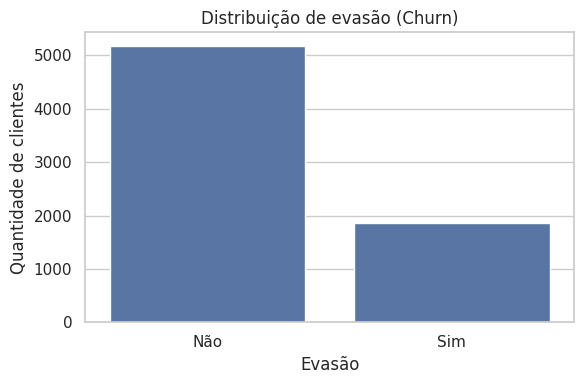

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='evasao', order=['Não','Sim'])
ax.set_title('Distribuição de evasão (Churn)')
ax.set_xlabel('Evasão')
ax.set_ylabel('Quantidade de clientes')
plt.tight_layout()
plt.show()

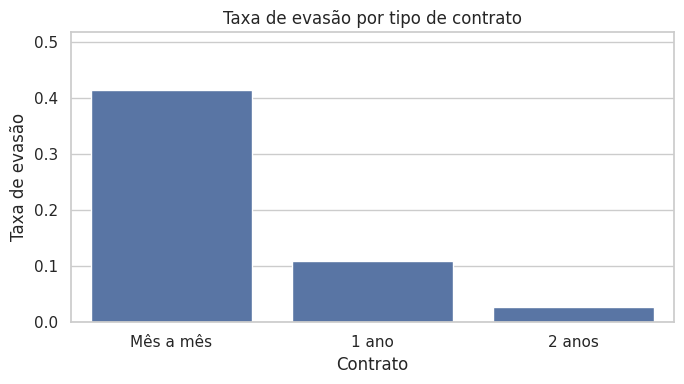

,churn_flag
contrato_pt,
Mês a mês,41.3
1 ano,10.9
2 anos,2.8


In [ ]:
rate_contrato = df.groupby('contrato_pt')['churn_flag'].mean().sort_values(ascending=False)

plt.figure(figsize=(7,4))
ax = sns.barplot(x=rate_contrato.index, y=rate_contrato.values)
ax.set_title('Taxa de evasão por tipo de contrato')
ax.set_xlabel('Contrato')
ax.set_ylabel('Taxa de evasão')
ax.set_ylim(0, rate_contrato.max()*1.25)
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

(rate_contrato*100).round(1)

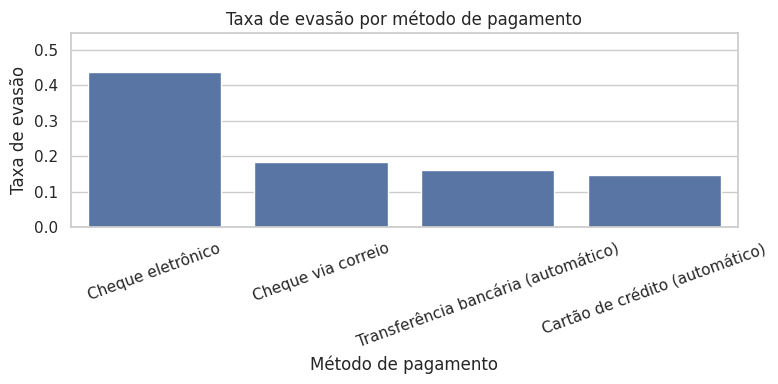

,churn_flag
pagamento_pt,
Cheque eletrônico,43.8
Cheque via correio,18.5
Transferência bancária (automático),16.2
Cartão de crédito (automático),14.8


In [ ]:
rate_pagamento = df.groupby('pagamento_pt')['churn_flag'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
ax = sns.barplot(x=rate_pagamento.index, y=rate_pagamento.values)
ax.set_title('Taxa de evasão por método de pagamento')
ax.set_xlabel('Método de pagamento')
ax.set_ylabel('Taxa de evasão')
ax.set_ylim(0, rate_pagamento.max()*1.25)
ax.tick_params(axis='x', rotation=20)
plt.tight_layout()
plt.show()

(rate_pagamento*100).round(1)

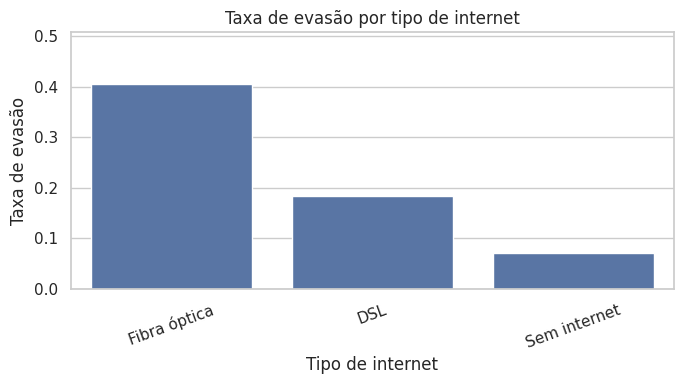

,churn_flag
internet_pt,
Fibra óptica,40.6
DSL,18.4
Sem internet,7.1


In [ ]:
rate_internet = df.groupby('internet_pt')['churn_flag'].mean().sort_values(ascending=False)

plt.figure(figsize=(7,4))
ax = sns.barplot(x=rate_internet.index, y=rate_internet.values)
ax.set_title('Taxa de evasão por tipo de internet')
ax.set_xlabel('Tipo de internet')
ax.set_ylabel('Taxa de evasão')
ax.set_ylim(0, rate_internet.max()*1.25)
ax.tick_params(axis='x', rotation=20)
plt.tight_layout()
plt.show()

(rate_internet*100).round(1)

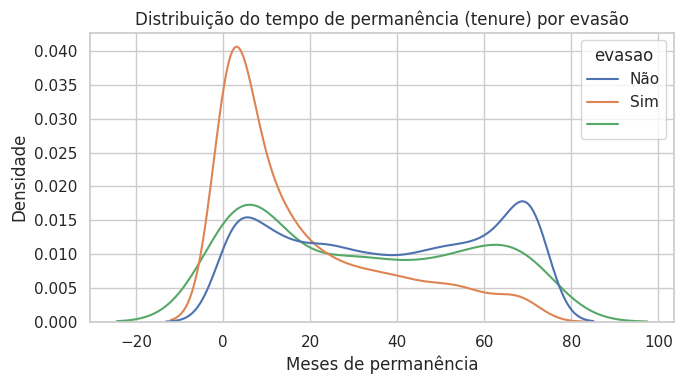

In [ ]:
# 6.5 Distribuição do tempo de permanência (tenure) por evasão
plt.figure(figsize=(7,4))
ax = sns.kdeplot(data=df, x='customer_tenure', hue='evasao', common_norm=False)
ax.set_title('Distribuição do tempo de permanência (tenure) por evasão')
ax.set_xlabel('Meses de permanência')
ax.set_ylabel('Densidade')
plt.tight_layout()
plt.show()

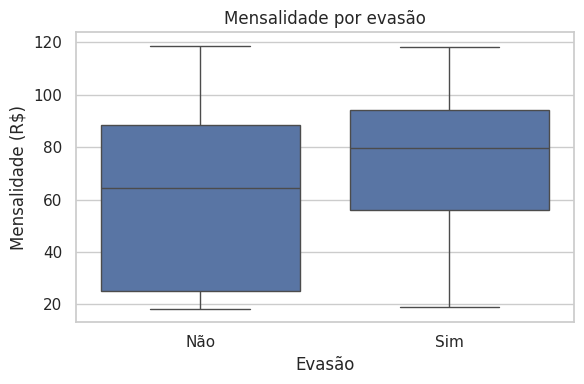

,mean,median,count
evasao,,,
,63.41,69.10,224
Não,61.27,64.43,5174
Sim,74.44,79.65,1869


In [ ]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(data=df, x='evasao', y='account_charges_monthly', order=['Não','Sim'])
ax.set_title('Mensalidade por evasão')
ax.set_xlabel('Evasão')
ax.set_ylabel('Mensalidade (R$)')
plt.tight_layout()
plt.show()

df.groupby('evasao')['account_charges_monthly'].agg(['mean','median','count']).round(2)

##Combinações de variáveis

In [ ]:
pivot_ci = pd.pivot_table(df, index='internet_pt', columns='contrato_pt', values='churn_flag', aggfunc='mean')
(pivot_ci*100).round(1)

contrato_pt,1 ano,2 anos,Mês a mês
internet_pt,,,
DSL,9.0,1.9,31.2
Fibra óptica,18.6,7.1,52.8
Sem internet,2.4,0.8,18.2


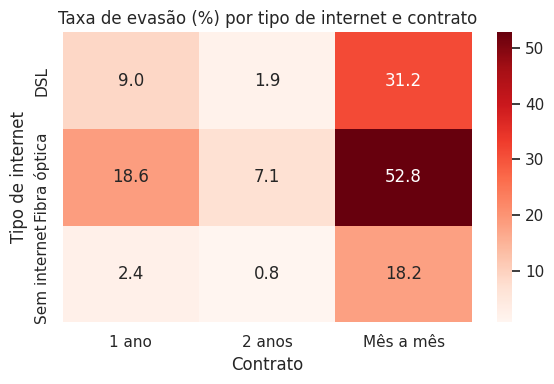

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.heatmap((pivot_ci*100).round(1), annot=True, fmt='.1f', cmap='Reds')
ax.set_title('Taxa de evasão (%) por tipo de internet e contrato')
ax.set_xlabel('Contrato')
ax.set_ylabel('Tipo de internet')
plt.tight_layout()
plt.show()

In [ ]:
pivot_cp = pd.pivot_table(df, index='pagamento_pt', columns='contrato_pt', values='churn_flag', aggfunc='mean')
(pivot_cp*100).round(1)

contrato_pt,1 ano,2 anos,Mês a mês
pagamento_pt,,,
Cartão de crédito (automático),9.9,2.2,32.0
Cheque eletrônico,17.8,7.6,51.9
Cheque via correio,6.6,0.8,30.5
Transferência bancária (automático),9.5,3.3,33.1


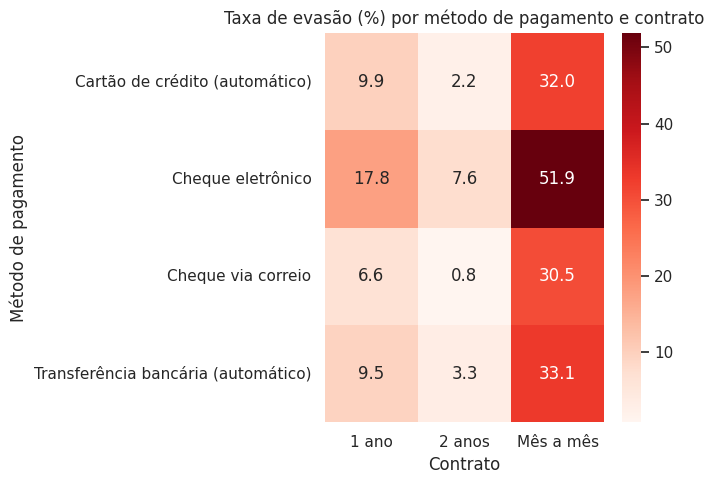

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.heatmap((pivot_cp*100).round(1), annot=True, fmt='.1f', cmap='Reds')
ax.set_title('Taxa de evasão (%) por método de pagamento e contrato')
ax.set_xlabel('Contrato')
ax.set_ylabel('Método de pagamento')
plt.tight_layout()
plt.show()

In [ ]:
pivot_tc = pd.pivot_table(df, index='faixa_tenure', columns='contrato_pt', values='churn_flag', aggfunc='mean')
(pivot_tc*100).round(1)

/tmp/ipython-input-1392052370.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_tc = pd.pivot_table(df, index='faixa_tenure', columns='contrato_pt', values='churn_flag', aggfunc='mean')


contrato_pt,1 ano,2 anos,Mês a mês
faixa_tenure,,,
0-6,10.0,0.0,53.2
7-12,10.3,0.0,40.6
13-24,8.0,0.0,37.0
25-48,10.3,2.1,31.7
49-72,12.4,3.2,25.3


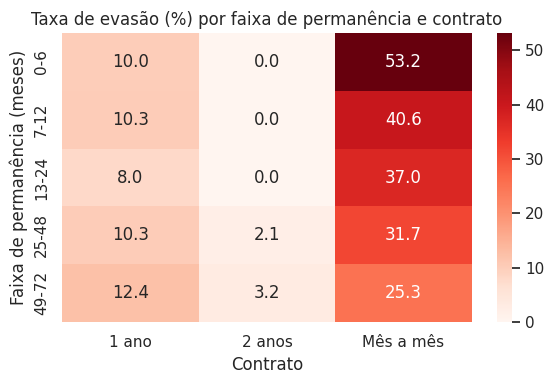

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.heatmap((pivot_tc*100).round(1), annot=True, fmt='.1f', cmap='Reds')
ax.set_title('Taxa de evasão (%) por faixa de permanência e contrato')
ax.set_xlabel('Contrato')
ax.set_ylabel('Faixa de permanência (meses)')
plt.tight_layout()
plt.show()

##Foco em clientes de fibra óptica


In [ ]:
fibra = df[df['internet_internetservice'] == 'Fiber optic'].copy()
print('Clientes com fibra óptica:', len(fibra))

for col in ['internet_onlinesecurity_pt','internet_techsupport_pt','account_paperlessbilling_pt']:
    if col in fibra.columns:
        print('\nChurn na fibra por:', col)
        display(tabela_churn_por_coluna(fibra, col))

Clientes com fibra óptica: 3198

Churn na fibra por: internet_onlinesecurity_pt


,qtd_clientes,taxa_evasao
internet_onlinesecurity_pt,,
Não,2329,47.8
Sim,869,21.1



Churn na fibra por: internet_techsupport_pt


,qtd_clientes,taxa_evasao
internet_techsupport_pt,,
Não,2302,47.8
Sim,896,21.9



Churn na fibra por: account_paperlessbilling_pt


,qtd_clientes,taxa_evasao
account_paperlessbilling_pt,,
Sim,2478,43.1
Não,720,31.8


##Segmentação — perfis de alto e baixo risco

In [ ]:
def resumo_segmento(nome: str, d: pd.DataFrame) -> pd.Series:
    return pd.Series({
        'segmento': nome,
        'qtd_clientes': len(d),
        'taxa_evasao_%': round(d['churn_flag'].mean()*100, 2) if len(d) else np.nan,
        'mensalidade_media': round(d['account_charges_monthly'].mean(), 2) if len(d) else np.nan,
        'tenure_mediana': round(d['customer_tenure'].median(), 2) if len(d) else np.nan,
    })

segmentos = []

#Alto risco clássico: mês a mês + cheque eletrônico + fibra
seg1 = (df['account_contract'] == 'Month-to-month') & (df['account_paymentmethod'] == 'Electronic check') & (df['internet_internetservice'] == 'Fiber optic')
segmentos.append(resumo_segmento('Alto risco: Mês a mês + Cheque eletrônico + Fibra', df[seg1]))

#Baixo risco: 2 anos + pagamento automático
seg2 = (df['account_contract'] == 'Two year') & (df['account_paymentmethod'].isin(['Bank transfer (automatic)','Credit card (automatic)']))
segmentos.append(resumo_segmento('Baixo risco: 2 anos + Pagamento automático', df[seg2]))

#Risco moderado: Mês a mês + Fibra, independentemente do pagamento
seg3 = (df['account_contract'] == 'Month-to-month') & (df['internet_internetservice'] == 'Fiber optic')
segmentos.append(resumo_segmento('Mês a mês + Fibra (todas formas de pagamento)', df[seg3]))

#Novos clientes: tenure <= 6 meses
seg4 = df['customer_tenure'] <= 6
segmentos.append(resumo_segmento('Clientes muito novos (tenure <= 6 meses)', df[seg4]))

#Clientes antigos: tenure >= 48 meses
seg5 = df['customer_tenure'] >= 48
segmentos.append(resumo_segmento('Clientes muito antigos (tenure >= 48 meses)', df[seg5]))

#Geral
segmentos.append(resumo_segmento('Geral', df))

segmentos_df = pd.DataFrame(segmentos)
segmentos_df

,segmento,qtd_clientes,taxa_evasao_%,mensalidade_media,tenure_mediana
0,Alto risco: Mês a mês + Cheque eletrônico + Fibra,1357,58.14,87.22,13.0
1,Baixo risco: 2 anos + Pagamento automático,1178,2.72,64.47,67.0
2,Mês a mês + Fibra (todas formas de pagamento),2199,52.84,87.02,16.0
3,Clientes muito novos (tenure <= 6 meses),1536,51.04,54.62,2.0
4,Clientes muito antigos (tenure >= 48 meses),2376,9.34,73.69,64.0
5,Geral,7267,25.72,64.72,29.0


## Ranking de perfis combinados


In [ ]:
cols_grupo = ['contrato_pt','pagamento_pt','internet_pt','faixa_tenure']

agr = (df.groupby(cols_grupo)['churn_flag']
         .agg(qtd_clientes='size', taxa_evasao='mean')
         .reset_index())
agr['taxa_evasao'] = (agr['taxa_evasao']*100).round(1)

# Filtrar grupos com pelo menos 50 clientes para evitar ruído
agr_filtrado = agr[agr['qtd_clientes'] >= 50].sort_values('taxa_evasao', ascending=False)

print('Top 15 perfis de maior churn (min 50 clientes):')
display(agr_filtrado.head(15))

Top 15 perfis de maior churn (min 50 clientes):


/tmp/ipython-input-1813375397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agr = (df.groupby(cols_grupo)['churn_flag']


,contrato_pt,pagamento_pt,internet_pt,faixa_tenure,qtd_clientes,taxa_evasao
168,Mês a mês,Cheque eletrônico,Fibra óptica,0-6,454,73.1
186,Mês a mês,Cheque via correio,Fibra óptica,0-6,99,60.6
169,Mês a mês,Cheque eletrônico,Fibra óptica,7-12,200,58.5
170,Mês a mês,Cheque eletrônico,Fibra óptica,13-24,262,57.3
162,Mês a mês,Cheque eletrônico,DSL,0-6,217,54.8
171,Mês a mês,Cheque eletrônico,Fibra óptica,25-48,298,47.0
152,Mês a mês,Cartão de crédito (automático),Fibra óptica,13-24,63,44.4
180,Mês a mês,Cheque via correio,DSL,0-6,198,43.9
207,Mês a mês,Transferência bancária (automático),Fibra óptica,25-48,106,39.6
144,Mês a mês,Cartão de crédito (automático),DSL,0-6,59,35.6


##Visão executiva


In [ ]:
# 11.1 Barra interativa: taxa de evasão por contrato (pt-br)
rate_contract = (df.groupby('contrato_pt')['churn_flag']
                   .mean()
                   .reset_index()
                   .rename(columns={'churn_flag':'taxa_evasao'}))
rate_contract['taxa_evasao'] = (rate_contract['taxa_evasao']*100).round(1)

fig = px.bar(rate_contract.sort_values('taxa_evasao', ascending=False),
             x='contrato_pt', y='taxa_evasao',
             title='Taxa de evasão por tipo de contrato',
             labels={'contrato_pt':'Contrato','taxa_evasao':'Taxa de evasão (%)'})
fig.update_layout(yaxis_range=[0, rate_contract['taxa_evasao'].max()*1.2])
fig.show()

In [ ]:
pivot_tc_pct = (pd.pivot_table(df, index='faixa_tenure', columns='contrato_pt', values='churn_flag', aggfunc='mean')*100).round(1)

fig = px.imshow(
    pivot_tc_pct,
    text_auto=True,
    aspect='auto',
    title='Taxa de evasão (%) por faixa de permanência e contrato',
    labels=dict(x='Contrato', y='Faixa de permanência (meses)', color='Evasão (%)')
)
fig.show()

/tmp/ipython-input-1002510570.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



##Conclusões principais

A partir desta análise mais completa, destacam-se:

1. **Contrato** é o maior driver: clientes em planos **mês a mês** apresentam taxa de evasão muito superior à de 1 ano e 2 anos.
2. **Método de pagamento** importa bastante: **Cheque eletrônico** concentra churn elevado, enquanto pagamentos automáticos (cartão e transferência) estão associados a menor evasão.
3. **Fibra óptica** tem churn alto, especialmente quando combinada com:
   - Contrato mês a mês
   - Falta de segurança online e suporte técnico
4. **Tempo de permanência (tenure)**: churn é extremamente alto nos primeiros meses (0–6), reduzindo à medida que o cliente envelhece na base.
5. **Preço/mensalidade**: quem evade paga, em média, mensalidades mais altas e tem menor tempo de casa.
6. Segmentos como **"Mês a mês + Cheque eletrônico + Fibra"** aparecem consistentemente como bolsões de alto risco.

Esses achados dão base para estratégias como:
- Incentivar migração de mês a mês → 1 ano/2 anos
- Migrar clientes de cheque eletrônico → pagamento automático
- Programas de onboarding e retenção nos primeiros 180 dias
- Pacotes de valor para a fibra (segurança online + suporte técnico) e revisão de preço/percepção de valor.
